# Separate the filaments in N2Hp and HC3N

We know that the filament forks from south to north. Then, we know that there are two components that overlap each other. These correspond to two apparent layers in velocity, as suggested by the KDE of the velocities 

We will first separate the 1 Gaussian fit into the two sides of the filament. After testing DBSCAN, KMEANS, and HDBSCAN, DBSCAN gives the best results

In [1]:
import numpy as np
import pandas as pd
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
import warnings
import os
import sys
sys.path.append('../')
from setup import *
import warnings
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib widget

from sklearn.cluster import DBSCAN, HDBSCAN, AgglomerativeClustering #, OPTICS, cluster_optics_dbscan
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

import hdbscan # I want to test this one that has more complete functions

from tqdm.notebook import tqdm
seed = 42



In [2]:
run_DBSCAN = True
run_manual = False
run_HDBSCAN = False
run_aggl = False

In [3]:
# we first load our table of features
mol1 = 'N2Hp' # remember to do the bayes fitting for all hyperfine components
mol1_as_features_file = bayesfolder + 'nested-sampling/{0}/{0}_feature_table_bayes_QA.csv'.format(mol1)
header_mol1 = fits.getheader('../data/NGC1333-N2Hp_match_kms_F1F_01_12.fits')
mol1label = r'N$_2$H$^+$'
ncomp1 = 2
ncompfilebayes_mol1 = bayesfolder + 'nested-sampling/{}/npeaks_cut5_noislands_QA.fits'.format(mol1)

ds_mol1_feats = pd.read_csv(mol1_as_features_file)
ds_mol1_feats.rename(columns={'Unnamed: 0':'Index_original'}, inplace = True)
print('We have ', np.shape(ds_mol1_feats)[0], 'points for {}'.format(mol1))

mol2 = 'HC3N' 
mol2_as_features_file = bayesfolder + 'nested-sampling/{0}/{0}_feature_table_bayes_QA.csv'.format(mol2)
mol2label = r'HC$_3$N'
header_mol2 = fits.getheader('../data/NGC1333_HC3N_L24-merged_small_K.fits')
ncomp2 = 3
ncompfilebayes_mol2 = bayesfolder + 'nested-sampling/{}/npeaks_cut5_noislands_QA.fits'.format(mol2)

ds_mol2_feats = pd.read_csv(mol2_as_features_file)
ds_mol2_feats.rename(columns={'Unnamed: 0':'Index_original'}, inplace = True)
print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2))

We have  94864 points for N2Hp
We have  56771 points for HC3N


In [4]:
## lets do an extra filtering of N2Hp just in case
ds_mol1_feats = ds_mol1_feats.query('e_sigma_v/sigma_v < 0.25')
print('We have ', np.shape(ds_mol1_feats)[0], 'points for {}'.format(mol1) + 'after filtering error in sigma')
ds_mol1_feats = ds_mol1_feats.query('e_vlsr/vlsr < 0.25')
print('We have ', np.shape(ds_mol1_feats)[0], 'points for {}'.format(mol1) + 'after filtering error in velocity')
ds_mol1_feats = ds_mol1_feats.query('e_amplitude/amplitude < 0.25')
print('We have ', np.shape(ds_mol1_feats)[0], 'points for {}'.format(mol1) + 'after filtering error in amplitude')

# we also don't really trust the sigma that are beyond 1 (can be interesting to note they exist but not for the cloud composition
ds_mol1_feats = ds_mol1_feats.query('sigma_v < 1')
print('We have ', np.shape(ds_mol1_feats)[0], 'points for {}'.format(mol1) + 'after filtering for sigma >=1')

ds_mol1_feats = ds_mol1_feats.query('vlsr<9.1')
ds_mol1_feats = ds_mol1_feats.query('vlsr>6.1')
print('We have ', np.shape(ds_mol1_feats)[0], 'points for {}'.format(mol1) + 'after filtering for vlsr>9.1 and vlsr < 6.1')

if not os.path.exists(mol1_as_features_file[:-4] + '_pandasQA.csv'): ds_mol1_feats.to_csv(mol1_as_features_file[:-4] + '_pandasQA.csv')
# we need to take the outflow enhanced pixels by hand

We have  82189 points for N2Hpafter filtering error in sigma
We have  82189 points for N2Hpafter filtering error in velocity
We have  82063 points for N2Hpafter filtering error in amplitude
We have  81721 points for N2Hpafter filtering for sigma >=1
We have  81657 points for N2Hpafter filtering for vlsr>9.1 and vlsr < 6.1


In [5]:
# for HC3N we will need to take out the points consisting on outflow
# we do an extra quality assessment to filter out components with high error
# its much easier doing this in pandas

ds_mol2_feats = ds_mol2_feats.query('e_sigma_v/sigma_v < 0.5')
print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2) + 'after filtering error in sigma')
ds_mol2_feats = ds_mol2_feats.query('e_vlsr/vlsr < 0.5')
print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2) + 'after filtering error in velocity')
ds_mol2_feats = ds_mol2_feats.query('e_amplitude/amplitude < 0.5')
print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2) + 'after filtering error in velocity')

if not os.path.exists(mol2_as_features_file[:-4] + '_pandasQA.csv'): ds_mol2_feats.to_csv(mol2_as_features_file[:-4] + '_pandasQA.csv')
# we need to take the outflow enhanced pixels by hand
ds_mol2_feats = ds_mol2_feats.query('vlsr < 9')
ds_mol2_feats = ds_mol2_feats.query('vlsr > 5')
ds_mol2_feats = ds_mol2_feats.query('sigma_v < 1')
print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2) + 'after filtering velocity and sigma of outflows')
if not os.path.exists(mol2_as_features_file[:-4] + '_pandasQA_nooutflows.csv'): ds_mol2_feats.to_csv(mol2_as_features_file[:-4] + '_pandasQA_nooutflows.csv')


print('We have ', np.shape(ds_mol2_feats)[0], 'points for {}'.format(mol2))

We have  53846 points for HC3Nafter filtering error in sigma
We have  53846 points for HC3Nafter filtering error in velocity
We have  53824 points for HC3Nafter filtering error in velocity
We have  52019 points for HC3Nafter filtering velocity and sigma of outflows
We have  52019 points for HC3N


In [6]:
## To track the position of a pixel, we can make an array where
x_max_mol1 = header_mol1['NAXIS1']
y_max_mol1 = header_mol1['NAXIS2']
linmax = x_max_mol1 * y_max_mol1
map_track = np.reshape(np.linspace(0, linmax-1, int(linmax)), (int(y_max_mol1), int(x_max_mol1)))
ds_mol1_feats['Position'] = np.zeros(np.shape(ds_mol1_feats.index.values))

for i in ds_mol1_feats.index.values:
    x = int(ds_mol1_feats.loc[i, 'x_pix'])
    y = int(ds_mol1_feats.loc[i, 'y_pix'])
    ds_mol1_feats.loc[i, 'Position'] = map_track[y, x]
    
x_max_mol2 = header_mol2['NAXIS1']
y_max_mol2 = header_mol2['NAXIS2']
linmax_2 = x_max_mol2 * y_max_mol2
map_track_2 = np.reshape(np.linspace(0, linmax_2-1, int(linmax_2)), (int(y_max_mol2), int(x_max_mol2)))
ds_mol2_feats['Position'] = np.zeros(np.shape(ds_mol2_feats.index.values))

for i in ds_mol2_feats.index.values:
    x = int(ds_mol2_feats.loc[i, 'x_pix'])
    y = int(ds_mol2_feats.loc[i, 'y_pix'])
    ds_mol2_feats.loc[i, 'Position'] = map_track_2[y, x]

In [7]:
# we select which columns we want to separate by
ds_cluster1_mol1 = ds_mol1_feats[['x_pix', 'y_pix', 'amplitude', 'vlsr', 'sigma_v']]
ds_cluster2_mol1 = ds_mol1_feats[['x_pix', 'y_pix', 'vlsr']]
ds_cluster3_mol1 = ds_mol1_feats[['x_pix', 'y_pix', 'vlsr', 'sigma_v']]
ds_cluster4_mol1 = ds_mol1_feats[['x_pix', 'y_pix', 'amplitude', 'vlsr']]

ds_cluster1_mol2 = ds_mol2_feats[['x_pix', 'y_pix', 'amplitude', 'vlsr', 'sigma_v']]
ds_cluster2_mol2 = ds_mol2_feats[['x_pix', 'y_pix', 'vlsr']]
ds_cluster3_mol2 = ds_mol2_feats[['x_pix', 'y_pix', 'vlsr', 'sigma_v']]
ds_cluster4_mol2 = ds_mol2_feats[['x_pix', 'y_pix', 'sigma_v']]

In [8]:
# we scale the features so that they are comparable
scaler1_mol1 = StandardScaler()
X1_mol1 = scaler1_mol1.fit_transform(ds_cluster1_mol1)
scaler2_mol1 = StandardScaler()
X2_mol1 = scaler2_mol1.fit_transform(ds_cluster2_mol1)
X2_mol1_weighted = X2_mol1 * np.array([0.25, 0.25, 0.5]) # we give more weight to velocity
scaler3_mol1 = StandardScaler()
X3_mol1 = scaler3_mol1.fit_transform(ds_cluster3_mol1)
scaler4_mol1 = StandardScaler()
X4_mol1 = scaler4_mol1.fit_transform(ds_cluster4_mol1)

scaler1_mol2 = StandardScaler()
X1_mol2 = scaler1_mol2.fit_transform(ds_cluster1_mol2)
scaler2_mol2 = StandardScaler()
X2_mol2 = scaler2_mol2.fit_transform(ds_cluster2_mol2)
X2_mol2_weight = X2_mol2 * np.array([0.25, 0.25, 0.5])
scaler3_mol2 = StandardScaler()
X3_mol2 = scaler3_mol2.fit_transform(ds_cluster3_mol2)
scaler4_mol2 = StandardScaler()
X4_mol2 = scaler4_mol2.fit_transform(ds_cluster4_mol2)

In [ ]:
# fig = plt.figure()
# ax = fig.add_subplot(111)

# ax.violinplot(dataset=[X1_mol1.T[0], X1_mol1.T[1], X1_mol1.T[2],X1_mol1.T[3], X1_mol1.T[4]], showmeans=False, showmedians=True)
# ax.set_xticks([1, 2, 3, 4, 5], labels=['x', 'y', 'T', 'v', 'sigma'])

In [ ]:
### after we scale, we can look at the ranges with the violin plot for HC3N

# fig = plt.figure()
# ax = fig.add_subplot(111)

# ax.violinplot(dataset=[X1_mol2.T[0], X1_mol2.T[1], X1_mol2.T[2],X1_mol2.T[3], X1_mol2.T[4]], showmeans=False, showmedians=True)
# ax.set_xticks([1, 2, 3, 4, 5], labels=['x', 'y', 'T', 'v', 'sigma'])
# # ax.set_xticks([y + 1 for y in range(len(X1_mol2))], labels=['x']) #, 'y', 'T', 'v', 'sigma'

## DBSCAN

In [10]:
if run_DBSCAN: 
    min_samples_mol1 = 1000 #was 1000
    min_samples_mol2 = 400

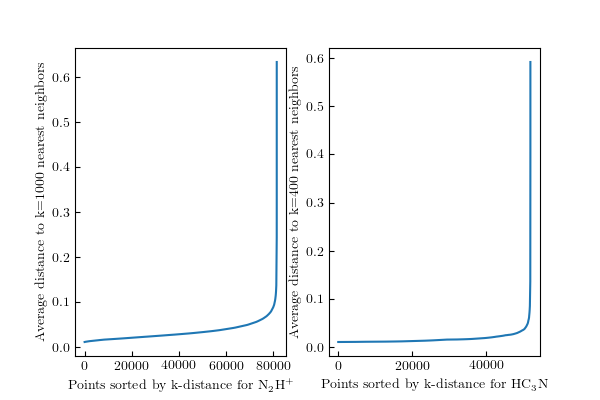

In [14]:
if run_DBSCAN:
    # average distance between each point and its k nearest neighbors
    neighbors_mol1 = NearestNeighbors(n_neighbors=min_samples_mol1, algorithm='kd_tree')
    neighbors_mol1.fit(X4_mol1)
    distances_mol1, indices_mol1 = neighbors_mol1.kneighbors(X4_mol1)
    distances_mol1 = np.sort(distances_mol1, axis=0)
    distances_mol1 = distances_mol1[:,1]
    
    neighbors_mol2 = NearestNeighbors(n_neighbors=min_samples_mol2, algorithm='kd_tree')
    neighbors_mol2.fit(X2_mol2)
    distances_mol2, indices_mol2 = neighbors_mol2.kneighbors(X2_mol2)
    distances_mol2 = np.sort(distances_mol2, axis=0)
    distances_mol2 = distances_mol2[:,1]
    fig, [ax1, ax2] = plt.subplots(ncols=2,figsize=(6,4))
    ax1.plot(distances_mol1)
    ax1.set_xlabel('Points sorted by k-distance for {}'.format(mol1label))
    ax1.set_ylabel('Average distance to k='+str(min_samples_mol1)+' nearest neighbors')
    
    ax2.plot(distances_mol2)
    ax2.set_xlabel('Points sorted by k-distance for {}'.format(mol2label))
    ax2.set_ylabel('Average distance to k='+str(min_samples_mol2)+' nearest neighbors')
    


We found a good set of parameters for DBSCAN N2Hp: epsilon = 0.352, minsamples = 1000, gives 5 groups and noise looks reasonable. With this, the fork belongs to neither of the main groups. 

In [19]:
if run_DBSCAN:
    db = DBSCAN(eps=0.4, min_samples=min_samples_mol1) #was 
    
    db.fit(X4_mol1)
    labels = db.labels_
    ds_mol1_feats['labels_dbscan'] = labels
    ds_cluster4_mol1['labels_dbscan'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))
    # unique_labels = set(labels)

Estimated number of clusters: 6
Estimated number of noise points: 59385
Total number of points: 81657


/tmp/ipykernel_34325/1343087930.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ds_cluster4_mol1['labels_dbscan'] = labels


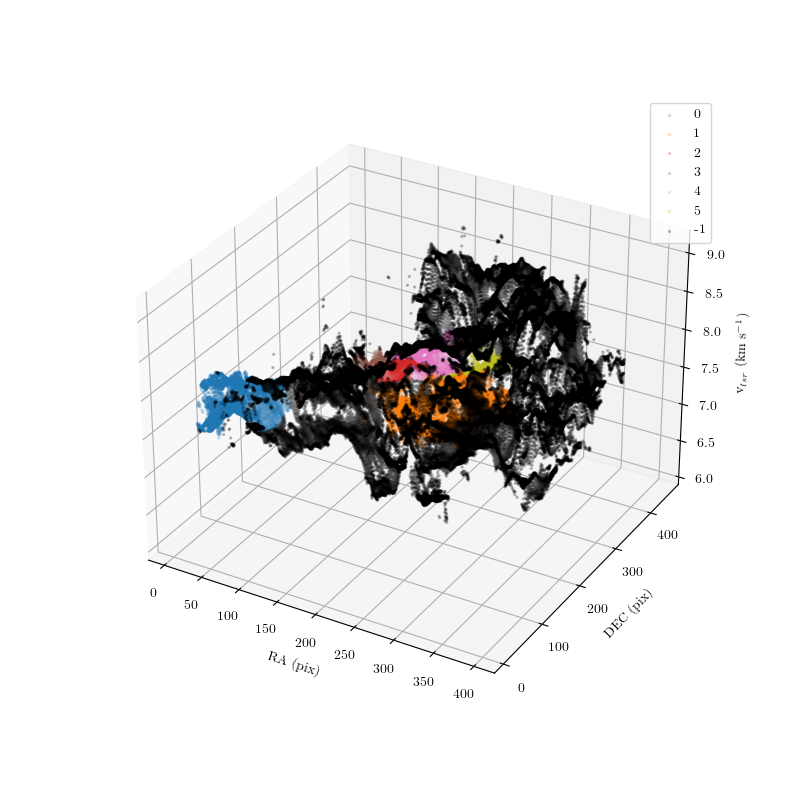

In [20]:
if run_DBSCAN:
    unique_labels = set(labels)
    colors = [plt.cm.tab10(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            # continue
        class_member_mask = labels == k
        # if k!=0 and k!=-1: continue

        xy = scaler4_mol1.inverse_transform(X4_mol1[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,3], s=2, color=col, alpha=0.2, label=k)
    # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
    ax.legend()

In [ ]:
if run_DBSCAN:
    db = DBSCAN(eps=0.34, min_samples=min_samples_mol1) #was 
    
    db.fit(X2_mol1)
    labels = db.labels_
    ds_mol1_feats['labels_dbscan'] = labels
    ds_cluster2_mol1['labels_dbscan'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))
    # unique_labels = set(labels)

In [ ]:
if run_DBSCAN:
    unique_labels = set(labels)
    colors = [plt.cm.tab10(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            # continue
        class_member_mask = labels == k
        # if k!=0 and k!=-1: continue

        xy = scaler3_mol1.inverse_transform(X3_mol1[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=2, color=col, alpha=0.2, label=k)
    # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
    ax.legend()

We know now that DBSCAN works best for N2Hp, now what we will do is check how many points are left as noise and if it is possible to cluster them. 

We first check how many components there are in each group

In [ ]:
if run_DBSCAN:
    clump0_mol1 = ds_mol1_feats[ds_mol1_feats['labels_dbscan']==0]
    clump1_mol1 = ds_mol1_feats[ds_mol1_feats['labels_dbscan']==1]
    clump2_mol1 = ds_mol1_feats[ds_mol1_feats['labels_dbscan']==2]
    clump3_mol1 = ds_mol1_feats[ds_mol1_feats['labels_dbscan']==3]
    clump4_mol1 = ds_mol1_feats[ds_mol1_feats['labels_dbscan']==4]
    clump_noise_mol1 = ds_mol1_feats[ds_mol1_feats['labels_dbscan']==-1]
    rad_assign = 6
    vel_average = np.nanmean(ds_mol1_feats['vlsr'])
    tmb_average = np.nanmean(ds_mol1_feats['amplitude'])

In [ ]:
if run_DBSCAN:
    repeated = len(clump0_mol1['Position'])-len(clump0_mol1['Position'].drop_duplicates())
    print('Cluster 0 has ',repeated,' repetitions')
    repeated = len(clump1_mol1['Position'])-len(clump1_mol1['Position'].drop_duplicates())
    print('Cluster 1 has ',repeated,' repetitions')
    repeated = len(clump2_mol1['Position'])-len(clump2_mol1['Position'].drop_duplicates())
    print('Cluster 2 has ',repeated,' repetitions')
    repeated = len(clump3_mol1['Position'])-len(clump3_mol1['Position'].drop_duplicates())
    print('Cluster 3 has ',repeated,' repetitions')
    repeated = len(clump4_mol1['Position'])-len(clump4_mol1['Position'].drop_duplicates())
    print('Cluster 4 has ',repeated,' repetitions')

In [ ]:
def dist_ar(xc=None, yc=None):
    """
    returns a 2D array with distance to each pixel from a custom centre pixel, (xc, yc)
    """
    d_ar = np.zeros(npeaks_map.shape)
    for i in range(d_ar.shape[0]):
        for j in range(d_ar.shape[1]):
            d_ar[i,j] = np.hypot(xc - j, yc - i)
        
    return d_ar

def para_dist(v1=None, v2=None, tmb1=None, tmb2=None, vel_norm=0.3, tmb_norm=3, w_vel=0.5):
    """
    returns normalised combined 'distance' in velocity and T_MB
    
    v1, v2 : velocities of the two pixels
    tmb1, tmb2 : main beam brightness temperatures of the two pixels
    
    vel_norm : normalisation factor for difference in velocities
    tmb_norm : normalisation factor for difference in T_MB
    
    w_vel : weight for velocity 'distance'. T_MB diff gets weight (1-w)

    """
    
    vl_dist = np.abs((v1 - v2) / vel_norm)
    tmb_dist = np.abs((tmb1 - tmb2) / tmb_norm)
    
    dist = np.hypot(vl_dist*w_vel, (1-w_vel)*tmb_dist)
    return dist


In [ ]:
if run_DBSCAN: #let it find its solution iteratively
    duplicates = clump0_mol1.duplicated(subset='Position', keep=False)
    clump0_mol1['Duplicate'] =  duplicates
    clump0_mol1_repeated = clump0_mol1[clump0_mol1['Duplicate']]
    clump0_mol1_unique = clump0_mol1.drop_duplicates(subset='Position', keep=False)
    add = 0
    while not clump0_mol1_repeated.empty:
        for pos in tqdm(reversed(clump0_mol1_repeated.drop_duplicates(subset='Position', keep='last')['Position'].values)):
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                repeated_set = clump0_mol1_repeated[clump0_mol1_repeated['Position'] == pos]
                x = repeated_set['x_pix'].values[0]
                y = repeated_set['x_pix'].values[0]
                clump0_mol1_vel = np.nan
                clump0_mol1_velarray = clump0_mol1_unique.query('x_pix> {0} and x_pix<{1} and y_pix>{2} and y_pix<{3}'.format(x-rad_assign-add, 
                                                                                                                             x+rad_assign+add, 
                                                                                                                             y-rad_assign-add, 
                                                                                                                             y+rad_assign+add))['vlsr']

                clump0_mol1_vel = np.nanmean(clump0_mol1_velarray)
                clump0_mol1_tmb = np.nanmean(clump0_mol1_velarray)
                if np.isnan(clump0_mol1_vel) or np.isnan(clump0_mol1_tmb): continue
                repeated_set['diff'] = para_dist(v1=repeated_set['vlsr'], v2=clump0_mol1_vel, tmb1=repeated_set['amplitude'], tmb2=clump0_mol1_tmb,
                                                vel_norm=vel_average, tmb_norm=tmb_average, w_vel=0.4) #np.abs(repeated_set['vlsr'] - clump0_mol1_vel)
                id_erase = repeated_set['diff'].idxmax()
                id_add = repeated_set['diff'].idxmin()
                ds_mol1_feats.loc[id_erase, 'labels_dbscan'] = -1
                clump0_mol1.drop(id_erase, axis=0, inplace=True)
                clump0_mol1_unique.loc[id_add] = clump0_mol1.loc[id_add]
                clump0_mol1_repeated.drop(repeated_set.index.values, inplace=True)
        add+=1
            

In [ ]:
if run_DBSCAN: #let it find its solution iteratively
    duplicates = clump2_mol1.duplicated(subset='Position', keep=False)
    clump2_mol1['Duplicate'] =  duplicates
    clump2_mol1_repeated = clump2_mol1[clump2_mol1['Duplicate']]
    clump2_mol1_unique = clump2_mol1.drop_duplicates(subset='Position', keep=False)
    add = 0
    while not clump2_mol1_repeated.empty:
        for pos in tqdm(reversed(clump2_mol1_repeated.drop_duplicates(subset='Position', keep='last')['Position'].values)):
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                repeated_set = clump2_mol1_repeated[clump2_mol1_repeated['Position'] == pos]
                x = repeated_set['x_pix'].values[0]
                y = repeated_set['x_pix'].values[0]
                clump2_mol1_vel = np.nan
                clump2_mol1_velarray = clump2_mol1_unique.query('x_pix> {0} and x_pix<{1} and y_pix>{2} and y_pix<{3}'.format(x-rad_assign-add, 
                                                                                                                             x+rad_assign+add, 
                                                                                                                             y-rad_assign-add, 
                                                                                                                             y+rad_assign+add))['vlsr']

                clump2_mol1_vel = np.nanmean(clump2_mol1_velarray)
                clump2_mol1_tmb = np.nanmean(clump2_mol1_velarray)
                if np.isnan(clump2_mol1_vel) or np.isnan(clump2_mol1_tmb): continue
                repeated_set['diff'] = para_dist(v1=repeated_set['vlsr'], v2=clump2_mol1_vel, tmb1=repeated_set['amplitude'], tmb2=clump2_mol1_tmb,
                                                vel_norm=vel_average, tmb_norm=tmb_average, w_vel=0.4) #np.abs(repeated_set['vlsr'] - clump2_mol1_vel)
                id_erase = repeated_set['diff'].idxmax()
                id_add = repeated_set['diff'].idxmin()
                ds_mol1_feats.loc[id_erase, 'labels_dbscan'] = -1
                clump2_mol1.drop(id_erase, axis=0, inplace=True)
                clump2_mol1_unique.loc[id_add] = clump2_mol1.loc[id_add]
                clump2_mol1_repeated.drop(repeated_set.index.values, inplace=True)
        add+=1
            

In [ ]:
if run_DBSCAN: #let it find its solution iteratively
    duplicates = clump4_mol1.duplicated(subset='Position', keep=False)
    clump4_mol1['Duplicate'] =  duplicates
    clump4_mol1_repeated = clump4_mol1[clump4_mol1['Duplicate']]
    clump4_mol1_unique = clump4_mol1.drop_duplicates(subset='Position', keep=False)
    add = 0
    while not clump4_mol1_repeated.empty:
        for pos in tqdm(reversed(clump4_mol1_repeated.drop_duplicates(subset='Position', keep='last')['Position'].values)):
            with warnings.catch_warnings():
                warnings.simplefilter('ignore')
                repeated_set = clump4_mol1_repeated[clump4_mol1_repeated['Position'] == pos]
                x = repeated_set['x_pix'].values[0]
                y = repeated_set['x_pix'].values[0]
                clump4_mol1_vel = np.nan
                clump4_mol1_velarray = clump4_mol1_unique.query('x_pix> {0} and x_pix<{1} and y_pix>{2} and y_pix<{3}'.format(x-rad_assign-add, 
                                                                                                                             x+rad_assign+add, 
                                                                                                                             y-rad_assign-add, 
                                                                                                                             y+rad_assign+add))['vlsr']

                clump4_mol1_vel = np.nanmean(clump4_mol1_velarray)
                clump4_mol1_tmb = np.nanmean(clump4_mol1_velarray)
                if np.isnan(clump4_mol1_vel) or np.isnan(clump4_mol1_tmb): continue
                repeated_set['diff'] = para_dist(v1=repeated_set['vlsr'], v2=clump4_mol1_vel, tmb1=repeated_set['amplitude'], tmb2=clump4_mol1_tmb,
                                                vel_norm=vel_average, tmb_norm=tmb_average, w_vel=0.4) #np.abs(repeated_set['vlsr'] - clump4_mol1_vel)
                id_erase = repeated_set['diff'].idxmax()
                id_add = repeated_set['diff'].idxmin()
                ds_mol1_feats.loc[id_erase, 'labels_dbscan'] = -1
                clump4_mol1.drop(id_erase, axis=0, inplace=True)
                clump4_mol1_unique.loc[id_add] = clump4_mol1.loc[id_add]
                clump4_mol1_repeated.drop(repeated_set.index.values, inplace=True)
        add+=1
            

Just for now, we will save these groups. What we are missing is to check the noise points to not lose information.

In [ ]:
if run_DBSCAN:
    clumps_tosave = [clump0_mol1,clump1_mol1,clump2_mol1,clump3_mol1,clump4_mol1]
    # we would now like to build some preliminary images
    cubefile_mol1 = '../bayes_frame/nested-sampling/{0}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol1)
    cubefile_clumps = 'cluster{0}_DBSCAN_{1}.fits'
    header_components_mol1 = fits.getheader(cubefile_mol1)
    
    for j, clump in enumerate(clumps_tosave):
        print('Saving clump ', j)
        cube_components_mol1 = np.zeros(np.shape(fits.getdata(cubefile_mol1))) * np.nan
        for i in tqdm(clump.index.values):
            x = int(clump.loc[i, 'x_pix'])
            y = int(clump.loc[i, 'y_pix'])
            cube_components_mol1[0, y, x] = clump.loc[i, 'amplitude']
            cube_components_mol1[1, y, x] = clump.loc[i, 'vlsr']
            cube_components_mol1[2, y, x] = clump.loc[i, 'sigma_v']
            cube_components_mol1[3, y, x] = clump.loc[i, 'e_amplitude']
            cube_components_mol1[4, y, x] = clump.loc[i, 'e_vlsr']
            cube_components_mol1[5, y, x] = clump.loc[i, 'e_sigma_v']


        fits.writeto(cubefile_clumps.format(j,mol1), cube_components_mol1, header_components_mol1)

All of the above was for N2Hp (molecule 1). Now we do the same for HC3N (molecule 2).

Maybe with HC3N an artificial separation at 7.5 km/s can suffice, as it is quite hard to interpret the clusters being obtained.

We got good results with epsilon=0.188 and min_samples=250

In [ ]:
if run_DBSCAN:
    db2 = DBSCAN(eps=0.25, min_samples=min_samples_mol2)
    
    db2.fit(X2_mol2)
    labels = db2.labels_
    ds_mol2_feats['labels_dbscan'] = labels
    ds_cluster2_mol2['labels_dbscan'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))
    # unique_labels = set(labels)

In [ ]:
if run_DBSCAN:
    unique_labels = set(labels)
    colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            # continue
        class_member_mask = labels == k

        xy = scaler2_mol2.inverse_transform(X2_mol2[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
    # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
    ax.legend()

Does not work so well for HC3N, as they are both sparse and concentrated groups and DBSCAN cannot handle both.

### DBSCAN test with more parameters
We know now that with x, y and velocity we can have certain layers, but how does it look like when we include the dispersion?

We are interested in this kind of grouping as if the dispersion tends to increase toward SVS13, this could support the idea that the north is affected by a wave coming from a bubble toward the north. However, this test is not relevant to detect diverging flows between the molecules, so only the x, y, vel is relevant to our goal. 

In [ ]:
# if run_DBSCAN: min_samples = 200

In [ ]:
# if run_DBSCAN:
#     #average distance between each point and its k nearest neighbors
#     neighbors = NearestNeighbors(n_neighbors=min_samples, algorithm='kd_tree')
#     neighbors.fit(X3)
#     distances, indices = neighbors.kneighbors(X3)
#     distances = np.sort(distances, axis=0)
#     distances = distances[:,1]

In [ ]:
# if run_DBSCAN:
#     fig = plt.figure()
#     ax = fig.add_subplot(111)
#     ax.plot(distances)
#     ax.set_xlabel('Points sorted by k-distance for {} neighbors'.format(min_samples))
#     ax.set_ylabel('Average distance to k='+str(min_samples)+' nearest neighbors')

In [ ]:
# if run_DBSCAN:
#     db = DBSCAN(eps=0.25, min_samples=min_samples)
    
#     db.fit(X3)
#     labels = db.labels_
#     ds_cluster3['labels_dbscan'] = labels
#     n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
#     n_noise_ = list(labels).count(-1)

#     print("Estimated number of clusters: %d" % n_clusters_)
#     print("Estimated number of noise points: %d" % n_noise_)
#     print("Total number of points: %d" % len(labels))
#     # unique_labels = set(labels)

In [ ]:
# if run_DBSCAN:
#     unique_labels = set(labels)
#     colors = [plt.cm.inferno(each) for each in np.linspace(0, 1, len(unique_labels))]

#     fig = plt.figure(figsize=(8,8))
#     ax = fig.add_subplot(111, projection='3d')
#     ax.set_xlabel('RA (pix)')
#     ax.set_ylabel('DEC (pix)')
#     ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

#     for k, col in zip(unique_labels, colors):
#         if k == -1:
#             # Black used for noise.
#             col = [0, 0, 0, 1]
#             continue
#         class_member_mask = labels == k

#         xy = scaler3.inverse_transform(X3[class_member_mask])
#         ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
#     # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
#     ax.legend()

We can recover some of the noise points, but we can see that adding the dispersion independant of the eps and min_samples will always separate the north into smaller groups from the south.


## Manual separation

We do this for HC3N.

The approach right now has an issue: when sampling in the radius, it takes all the repeated components as well. 

In [ ]:
if run_manual:
    clump0_mol2 = ds_mol2_feats.query('vlsr > 7.5')
    clump1_mol2 = ds_mol2_feats.query('vlsr <= 7.5')
    # now we run Spandan's algorithm of distance
    rad_assign = 5
    vel_average = np.nanmean(ds_mol2_feats['vlsr'])
    tmb_average = np.nanmean(ds_mol2_feats['amplitude'])
    for i in tqdm(clump0_mol2.index.values): # we check all the array
        try:
            cx, cy = clump0_mol2.loc[i, 'x_pix'], clump0_mol2.loc[i, 'y_pix']
        except KeyError:
            continue # found a value that was repeated and that its not there anymore
        query = clump0_mol2.query('x_pix=={0} & y_pix=={1}'.format(cx, cy))
        if len(query) > 1:
            #it could happen that there are 3 components: 
            if len(query) > 2: index0, index1, index2 = query.index.values
            else: index0, index1 = query.index.values
            vel1 = query.loc[index0, 'vlsr']
            tmb1 = query.loc[index0, 'amplitude']
            vel2 = query.loc[index1, 'vlsr']
            tmb2 = query.loc[index1, 'amplitude']
            if len(query) > 2: 
                vel3 = query.loc[index2, 'vlsr']
                tmb3 = query.loc[index2, 'amplitude']
            #here fix
            rad_sample = clump0_mol2.query('x_pix>{0} & y_pix>{1} & x_pix<{2} & y_pix<{3}'.format(
                cx-rad_assign, cy-rad_assign, cx+rad_assign, cy+rad_assign))
            
            rad_sample.drop([index0, index1])
            if len(query) > 2: rad_sample.drop([index2])
            vel_mean = np.mean(rad_sample['vlsr'])
            t_mean = np.mean(rad_sample['amplitude'])
            if len(query) > 2: 
                distances = para_dist(v1=np.array([vel1, vel2, vel3]), v2=vel_mean, tmb1=np.array([tmb1, tmb2, tmb3]),
                                      tmb2=t_mean, vel_norm=vel_average, tmb_norm=tmb_average)
            else:
                distances = para_dist(v1=np.array([vel1, vel2]), v2=vel_mean, tmb1=np.array([tmb1, tmb2]),
                                      tmb2=t_mean, vel_norm=vel_average, tmb_norm=tmb_average)
            if np.argmin(distances) == 0:
                index = query.loc[index1, 'Index_original']
                indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel2)).index.values[0]
                ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                clump0_mol2 = clump0_mol2.drop([indexaux])
                if len(query) > 2:
                    index = query.loc[index2, 'Index_original']
                    indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel3)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump0_mol2 = clump0_mol2.drop([indexaux])
            elif np.argmin(distances) == 1:
                index = query.loc[index0, 'Index_original']
                indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel1)).index.values[0]
                ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                clump0_mol2 = clump0_mol2.drop([indexaux])
                if len(query) > 2:
                    index = query.loc[index2, 'Index_original']
                    indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel3)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump0_mol2 = clump0_mol2.drop([indexaux])
            if len(query) > 2:
                if np.argmin(distances) == 2:
                    index = query.loc[index1, 'Index_original']
                    indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel2)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump0_mol2 = clump0_mol2.drop([indexaux])
                    index = query.loc[index0, 'Index_original']
                    indexaux = clump0_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel1)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump0_mol2 = clump0_mol2.drop([indexaux])

In [ ]:
if run_manual:
    for i in tqdm(clump1_mol2.index.values): # we check all the array
        try:
            cx, cy = clump1_mol2.loc[i, 'x_pix'], clump1_mol2.loc[i, 'y_pix']
        except KeyError:
            continue # found a value that was repeated and that its not there anymore
        query = clump1_mol2.query('x_pix=={0} & y_pix=={1}'.format(cx, cy))
        if len(query) > 1:
            #it could happen that there are 3 components: 
            if len(query) > 2: index0, index1, index2 = query.index.values
            else: index0, index1 = query.index.values
            vel1 = query.loc[index0, 'vlsr']
            tmb1 = query.loc[index0, 'amplitude']
            vel2 = query.loc[index1, 'vlsr']
            tmb2 = query.loc[index1, 'amplitude']
            if len(query) > 2: 
                vel3 = query.loc[index2, 'vlsr']
                tmb3 = query.loc[index2, 'amplitude']
            rad_sample = clump1_mol2.query('x_pix>{0} & y_pix>{1} & x_pix<{2} & y_pix<{3}'.format(
                cx-rad_assign, cy-rad_assign, cx+rad_assign, cy+rad_assign))
            
            rad_sample.drop([index0, index1])
            if len(query) > 2: rad_sample.drop([index2])
            vel_mean = np.mean(rad_sample['vlsr'])
            t_mean = np.mean(rad_sample['amplitude'])
            if len(query) > 2: 
                distances = para_dist(v1=np.array([vel1, vel2, vel3]), v2=vel_mean, tmb1=np.array([tmb1, tmb2, tmb3]),
                                      tmb2=t_mean, vel_norm=vel_average, tmb_norm=tmb_average)
            else:
                distances = para_dist(v1=np.array([vel1, vel2]), v2=vel_mean, tmb1=np.array([tmb1, tmb2]),
                                      tmb2=t_mean, vel_norm=vel_average, tmb_norm=tmb_average)
            if np.argmin(distances) == 0:
                index = query.loc[index1, 'Index_original']
                indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel2)).index.values[0]
                ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                clump1_mol2 = clump1_mol2.drop([indexaux])
                if len(query) > 2:
                    index = query.loc[index2, 'Index_original']
                    indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel3)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump1_mol2 = clump1_mol2.drop([indexaux])
            elif np.argmin(distances) == 1:
                index = query.loc[index0, 'Index_original']
                indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel1)).index.values[0]
                ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                clump1_mol2 = clump1_mol2.drop([indexaux])
                if len(query) > 2:
                    index = query.loc[index2, 'Index_original']
                    indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel3)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump1_mol2 = clump1_mol2.drop([indexaux])
            if len(query) > 2:
                if np.argmin(distances) == 2:
                    index = query.loc[index1, 'Index_original']
                    indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel2)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump1_mol2 = clump1_mol2.drop([indexaux])
                    index = query.loc[index0, 'Index_original']
                    indexaux = clump1_mol2.query('x_pix=={0} & y_pix=={1} & vlsr=={2}'.format(cx, cy, vel1)).index.values[0]
                    ds_mol2_feats.loc[index, 'labels_dbscan'] = -1
                    clump1_mol2 = clump1_mol2.drop([indexaux]) 

In [ ]:
if run_manual:
    cubefile_mol2 = '../bayes_frame/nested-sampling/{0}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol2)
    cubefile_clump0 = 'cluster0_manual_{}.fits'.format(mol2)

    header_components_mol2 = fits.getheader(cubefile_mol2)
    cube_components_mol2 = np.zeros(np.shape(fits.getdata(cubefile_mol2))) * np.nan
    print('Saving clump 0 {}'.format(mol2))
    for i in tqdm(clump0_mol2.index.values):
        x = int(clump0_mol2.loc[i, 'x_pix'])
        y = int(clump0_mol2.loc[i, 'y_pix'])
        cube_components_mol2[0, y, x] = clump0_mol2.loc[i, 'amplitude']
        cube_components_mol2[1, y, x] = clump0_mol2.loc[i, 'vlsr']
        cube_components_mol2[2, y, x] = clump0_mol2.loc[i, 'sigma_v']
        cube_components_mol2[3, y, x] = clump0_mol2.loc[i, 'e_amplitude']
        cube_components_mol2[4, y, x] = clump0_mol2.loc[i, 'e_vlsr']
        cube_components_mol2[5, y, x] = clump0_mol2.loc[i, 'e_sigma_v']


    fits.writeto(cubefile_clump0, cube_components_mol2, header_components_mol2)

In [ ]:
if run_manual:
    cubefile_mol2 = '../bayes_frame/nested-sampling/{0}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol2)
    cubefile_clump1 = 'cluster1_manual_{}.fits'.format(mol2)

    header_components_mol2 = fits.getheader(cubefile_mol2)
    cube_components_mol2 = np.zeros(np.shape(fits.getdata(cubefile_mol2))) * np.nan
    print('Saving clump 1 {}'.format(mol2))
    for i in tqdm(clump1_mol2.index.values):
        x = int(clump1_mol2.loc[i, 'x_pix'])
        y = int(clump1_mol2.loc[i, 'y_pix'])
        cube_components_mol2[0, y, x] = clump1_mol2.loc[i, 'amplitude']
        cube_components_mol2[1, y, x] = clump1_mol2.loc[i, 'vlsr']
        cube_components_mol2[2, y, x] = clump1_mol2.loc[i, 'sigma_v']
        cube_components_mol2[3, y, x] = clump1_mol2.loc[i, 'e_amplitude']
        cube_components_mol2[4, y, x] = clump1_mol2.loc[i, 'e_vlsr']
        cube_components_mol2[5, y, x] = clump1_mol2.loc[i, 'e_sigma_v']


    fits.writeto(cubefile_clump1, cube_components_mol2, header_components_mol2)

## HDBSCAN

In [ ]:
if run_HDBSCAN:
    min_cluster_size_hdb_mol2 = 300 # was 200
    min_samples_hdb_mol2 = 200 #was 187
    
    min_cluster_size_hdb_mol1 = 80
    min_samples_hdb_mol1 = 80

In [ ]:
if run_HDBSCAN:
    # hdb = HDBSCAN(min_cluster_size = min_cluster_size_hdb, min_samples = min_samples_hdb)
    # hdb.fit(X2)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_hdb_mol1, min_samples=min_samples_hdb_mol1, gen_min_span_tree=True) #min_samples=min_samples_hdb_mol1,
    clusterer.fit(X2_mol1) # what if we use all parameters?
    
    labelshdb = clusterer.labels_
    ds_mol1_feats['labels_hdbscan'] = labelshdb
    ds_cluster2_mol1['labels_hdbscan'] = labelshdb

In [ ]:
fig, ax = plt.subplots()
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette(), axis=ax)


In [ ]:
if run_HDBSCAN:
    labels = clusterer.labels_
    # ds_mol1_feats['labels_hdbscan'] = labels
    # ds_cluster2_mol1['labels_hdbscan'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))
    # unique_labels = set(labels)

In [ ]:
if run_HDBSCAN:
    unique_labels = set(labels)
    palette = sns.color_palette()
    colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
    # colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

    
    xy = scaler2_mol1.inverse_transform(X2_mol1)
    ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=colors, alpha=0.2)
#     for k, col in zip(unique_labels, colors):
#         if k == -1:
#             # Black used for noise.
#             col = [0, 0, 0, 1]
#             # continue
#         class_member_mask = labels == k

#         xy = scaler2_mol1.inverse_transform(X2_mol1[class_member_mask])
#         ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
#     # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
#     ax.legend()

All above was for N2Hp, we see that this does not really work, we can now try with HC3N

**In the holes left by the noise in cluster 4 there is nothing to recover really**


In [ ]:
if run_HDBSCAN:
    # hdb = HDBSCAN(min_cluster_size = min_cluster_size_hdb, min_samples = min_samples_hdb)
    # hdb.fit(X2)
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_hdb_mol2, min_samples=min_samples_hdb_mol2, gen_min_span_tree=True)
    clusterer.fit(X2_mol2) # what if we use all parameters?
    
    # labelshdb = hdb.labels_
    # ds_cluster2['labels_hdbscan'] = labelshdb

In [ ]:
if run_HDBSCAN:
    fig, ax = plt.subplots()
    clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette(), axis=ax)


In [ ]:
if run_HDBSCAN:
    labels = clusterer.labels_
    ds_mol2_feats['labels_hdbscan'] = labels
    ds_cluster2_mol2['labels_hdbscan'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Estimated number of noise points: %d" % n_noise_)
    print("Total number of points: %d" % len(labels))
    # unique_labels = set(labels)

In [ ]:
if run_HDBSCAN:
    unique_labels = set(labels)
    # palette = sns.color_palette()
    # colors = [sns.desaturate(palette[col], sat)
    #               if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
    #               zip(clusterer.labels_, clusterer.probabilities_)]
    # colors = [palette[col]
    #               if col >= 0 else (0, 0, 0) for col, sat in
    #               zip(clusterer.labels_, clusterer.probabilities_)]
    colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')
    
    # xy = scaler2_mol2.inverse_transform(X2_mol2)
    # ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=colors, alpha=0.2)

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            # continue
        class_member_mask = labels == k

        xy = scaler2_mol2.inverse_transform(X2_mol2[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=4, color=col, alpha=0.2, label=k)
    # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
    ax.legend()

We see that, even if it has a lot of noise (which was expected from the fits to be honest), the groups make sense.
Now we check how large are the groups

In [ ]:
if run_HDBSCAN:
    clump0_mol2 = ds_mol2_feats[ds_mol2_feats['labels_hdbscan']==0]
    clump1_mol2 = ds_mol2_feats[ds_mol2_feats['labels_hdbscan']==1]
    clump2_mol2 = ds_mol2_feats[ds_mol2_feats['labels_hdbscan']==2]
    clump3_mol2 = ds_mol2_feats[ds_mol2_feats['labels_hdbscan']==3]
    clump4_mol2 = ds_mol2_feats[ds_mol2_feats['labels_hdbscan']==4]
    clump5_mol2 = ds_mol2_feats[ds_mol2_feats['labels_hdbscan']==5]
    clump6_mol2 = ds_mol2_feats[ds_mol2_feats['labels_hdbscan']==6]
    clump7_mol2 = ds_mol2_feats[ds_mol2_feats['labels_hdbscan']==7]
    clump_noise_mol2 = ds_mol2_feats[ds_mol2_feats['labels_hdbscan']==-1]
    rad_assign = 6
    vel_average = np.nanmean(ds_mol2_feats['vlsr'])
    tmb_average = np.nanmean(ds_mol2_feats['amplitude'])

In [ ]:
if run_HDBSCAN:
    repeated = len(clump0_mol2['Position'])-len(clump0_mol2['Position'].drop_duplicates())
    print('Cluster 0 has ',repeated,' repetitions')
    repeated = len(clump1_mol2['Position'])-len(clump1_mol2['Position'].drop_duplicates())
    print('Cluster 1 has ',repeated,' repetitions')
    repeated = len(clump2_mol2['Position'])-len(clump2_mol2['Position'].drop_duplicates())
    print('Cluster 2 has ',repeated,' repetitions')
    repeated = len(clump3_mol2['Position'])-len(clump3_mol2['Position'].drop_duplicates())
    print('Cluster 3 has ',repeated,' repetitions')
    repeated = len(clump4_mol2['Position'])-len(clump4_mol2['Position'].drop_duplicates())
    print('Cluster 4 has ',repeated,' repetitions')
    repeated = len(clump5_mol2['Position'])-len(clump5_mol2['Position'].drop_duplicates())
    print('Cluster 5 has ',repeated,' repetitions')
    repeated = len(clump6_mol2['Position'])-len(clump6_mol2['Position'].drop_duplicates())
    print('Cluster 6 has ',repeated,' repetitions')
    repeated = len(clump7_mol2['Position'])-len(clump7_mol2['Position'].drop_duplicates())
    print('Cluster 7 has ',repeated,' repetitions')

Nice! no repeated elements!

In [ ]:
if run_DBSCAN:
    clumps_tosave = [clump0_mol2,clump1_mol2,clump2_mol2,clump3_mol2,clump4_mol2,clump5_mol2,clump6_mol2,clump7_mol2]
    # we would now like to build some preliminary images
    cubefile_mol2 = '../bayes_frame/nested-sampling/{0}/NGC1333-SE-mle-x1_filtered_QA.fits'.format(mol2)
    cubefile_clumps = 'cluster{0}_HDBSCAN_{1}.fits'
    header_components_mol2 = fits.getheader(cubefile_mol2)
    
    for j, clump in enumerate(clumps_tosave):
        print('Saving clump ', j)
        cube_components_mol2 = np.zeros(np.shape(fits.getdata(cubefile_mol2))) * np.nan
        for i in tqdm(clump.index.values):
            x = int(clump.loc[i, 'x_pix'])
            y = int(clump.loc[i, 'y_pix'])
            cube_components_mol2[0, y, x] = clump.loc[i, 'amplitude']
            cube_components_mol2[1, y, x] = clump.loc[i, 'vlsr']
            cube_components_mol2[2, y, x] = clump.loc[i, 'sigma_v']
            cube_components_mol2[3, y, x] = clump.loc[i, 'e_amplitude']
            cube_components_mol2[4, y, x] = clump.loc[i, 'e_vlsr']
            cube_components_mol2[5, y, x] = clump.loc[i, 'e_sigma_v']


        fits.writeto(cubefile_clumps.format(j,mol2), cube_components_mol2, header_components_mol2)

## Agglomerative Clustering

If we want to save the noise points for analysis, even if they add noise to the data, we need a clustering method that returns all points

In [ ]:
if run_aggl:
    ward = AgglomerativeClustering(n_clusters=5, linkage="ward")
    ward.fit(X2_mol2)
    labels = ward.labels_
    ds_mol2_feats['labels_ward'] = labels
    ds_cluster2_mol2['labels_ward'] = labels
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

    print("Estimated number of clusters: %d" % n_clusters_)
    print("Total number of points: %d" % len(labels))
    # unique_labels = set(labels)

In [ ]:
if run_aggl:
    unique_labels = set(labels)
    colors = [plt.cm.tab10(each) for each in np.linspace(0, 1, len(unique_labels))]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('RA (pix)')
    ax.set_ylabel('DEC (pix)')
    ax.set_zlabel(r'v$_{lsr}$ (km s$^{-1}$)')

    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]
            # continue
        class_member_mask = labels == k
        # if k!=0 and k!=-1: continue

        xy = scaler2_mol2.inverse_transform(X2_mol2[class_member_mask])
        ax.scatter(xy[:,0], xy[:,1], xy[:,2], s=2, color=col, alpha=0.2, label=k)
    # ax.scatter(ra_yso_pix, dec_yso_pix, vlsr_yso, s=50, color='r')
    ax.legend()